# Modélisation Maganza 

Pareil que guide d'onde ? 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
### Définition des paramètres

W = 11e-3           #Largeur de la anche de clarinette
H = 0.48e-3         #Longueur de la anche de clarinette
gamma_air = 1.4     #Indice adiabatique
rho = 1.292         #Masse vol air
c = 343             #Vitesse son
rc = 3e-2           #rayon de la clarinette
Lc = 60e-2          #longueur clarinette
Sc = np.pi*rc**2    #section clarinette
pM = 0.1            #Pression de plaquage statique
f = c/(4*Lc)        #Fréquence premier mode
print(f)

omega = (2*np.pi*f)           
F1 = 2 * c / Lc                         

T = 2*Lc/c 
fe = 1/T  

Z0 = rho*c
Zc = Z0/Sc
eps = 0.05

### Temps de simulation

t_max = 1  #s
fe = 44100 #Hz
compute_time = np.arange(int(t_max/T))*T  # temps de calcul de l'amplitude
time_sim = np.arange(int(t_max*fe))/fe    # temps de "remplissage" pour avoir un signal carré

142.91666666666669


In [4]:
def coeffs(gamma,zeta):
    F0 = zeta*(1-gamma)*np.sqrt(gamma)
    A = zeta*(3 * gamma - 1) / 2 /np.sqrt(gamma)
    B = -zeta*(3*gamma+1)/8/gamma**(3/2)
    C = -zeta*(gamma+1)/16/gamma**(5/2)
    return F0,A,B,C

In [38]:
### Définition des fonctions

def Fapprox(p,F0,A,B,C,gamma=gamma,zeta=zeta):
    "Relation de couplage : u = F(p)"
    if gamma - p >= 1 or gamma - p < 0 :
        return 0
    else:
        return F0+A*p+B*p**2+C*p**3

def rotationGapprox(x,F0,A,B,C):
    theta = np.pi/4
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    y = Fapprox(x,F0,A,B,C)
    X = rotation_matrix @ np.array([[x],[y]])
    return X

def Gapprox(p,F0,A,B,C,liste_G,x_G):
    ind = 0
    while x_G[ind] < p:
        ind+=1
    
    return liste_G[ind]

def GCalApprox(x,F0,A,B,C,eps,Z0):
    X = Gapprox(x,F0,A,B,C)
    return X*(Z0-eps)/(Z0+eps)

def F(p,gamma, zeta):
    if gamma - p >= 1 or gamma - p < 0 :
        return 0
    else :
        return zeta*(1-gamma+p)*np.sqrt(gamma-p)
    
def rotation_G(x,gamma,zeta):
    theta = np.pi/4
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    y = F(x,gamma,zeta)
    X = rotation_matrix @ np.array([[x],[y]])
    return X

def G(p,gamma,zeta,liste_G,x_G):
    ind = 0
    while x_G[ind] <= p:
        ind+=1
    
    return liste_G[ind]

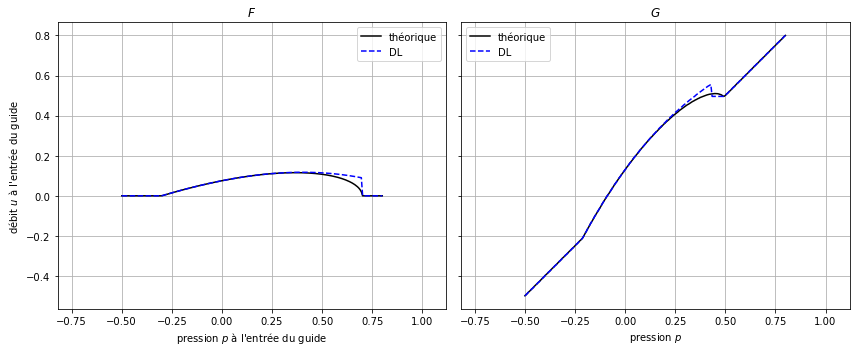

In [42]:
zeta = 0.3   #Zc*W*H*np.sqrt(2/rho/pM)  #W*H/Sc*np.sqrt(2*gamma_air*rho/pM) 
gamma = 0.7  #contrôle : rapport pm/pM

F0,A,B,C = coeffs(gamma,zeta)

# Définition des listes définissants les fonctions G (après rotation de F)

nb_pts = 1500
x = np.linspace(-1.5,1.5,nb_pts)
liste_G = np.zeros_like(x)
x_G = np.zeros_like(x)
for i in range(len(x)):
    X = rotation_G(x[i],gamma,zeta)
    liste_G[i] = X[1]
    x_G[i] = X[0]
    
liste_Gapprox = np.zeros_like(x)
x_Gapprox = np.zeros_like(x)
for i in range(len(x)):
    X = rotationGapprox(x[i],F0,A,B,C)
    liste_Gapprox[i] = X[1]
    x_Gapprox[i] = X[0]
        

x = np.linspace(-0.5,0.8,200)
yapprox = np.zeros_like(x)
for i in range(len(yapprox)):
    yapprox[i] = Fapprox(x[i],F0,A,B,C,gamma,zeta)

y = np.zeros_like(x)
for i in range(len(y)):
    y[i] = F(x[i],gamma,zeta)
    
zapprox = np.zeros_like(x)
for i in range(len(zapprox)):
    zapprox[i] = Gapprox(x[i],F0,A,B,C,liste_Gapprox,x_Gapprox)

z = np.zeros_like(x)
for i in range(len(z)):
    z[i] = G(x[i],gamma,zeta,liste_G,x_G)

fig, axs = plt.subplots(1,2,figsize=(12,5),sharey=True) 

axs[0].plot(x,y,'k',label="théorique")
axs[0].plot(x,yapprox,'b--',label="DL")
axs[0].set_xlabel(r"pression $p$ à l'entrée du guide")
axs[0].set_ylabel(r"débit $u$ à l'entrée du guide")
axs[0].set_title(r"$F$")
axs[0].axis('equal')
axs[0].grid()
axs[0].legend()
axs[1].plot(x,z,'k',label="théorique")
axs[1].plot(x,zapprox,'b--',label="DL")
axs[1].set_xlabel(r"pression $p$")
axs[1].set_title(r"$G$")
axs[1].axis('equal')
axs[1].grid()
axs[1].legend()

fig.tight_layout()

0.06910485196022778


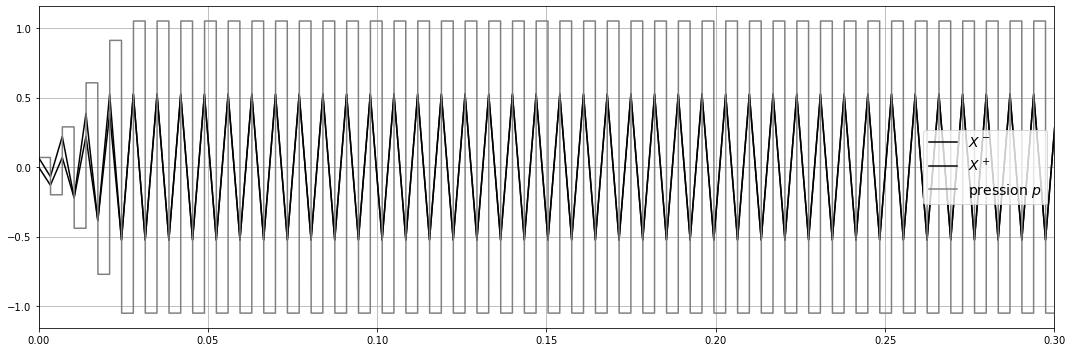

In [45]:
### Initialisation
Ncompute = len(compute_time)
Nsim = len(time_sim)

Xmoins_compute = np.zeros(Ncompute)
Xplus_compute = np.zeros(Ncompute)

zeta = 0.2
gamma = 0.6
F0,A,B,C = coeffs(gamma,zeta)

# Initialisation 

p0 = F0/(1-A)
u0 = Fapprox(p0,F0,A,B,C)

Xmoins_compute[0] = (p0 - u0)/2 
Xplus_compute[0] = (p0+u0)/2

# Calculs

for i in range(1,Ncompute):
    Xmoins_compute[i] = -Gapprox(Xmoins_compute[i-1],F0,A,B,C,liste_Gapprox,x_Gapprox)
    X = Gapprox(Xmoins_compute[i],F0,A,B,C,liste_Gapprox,x_Gapprox)
    Xplus_compute[i] = X
    
Xmoins = np.zeros(Nsim)
Xplus = np.zeros(Nsim)

i = 0
ind = 0
while i < Nsim and ind < Ncompute :
    Xmoins[i] = Xmoins_compute[ind]    
    Xplus[i] = Xplus_compute[ind]
    i+=1 
    time = i/fe
    ind = int(time//T) 
    
p = (Xmoins+Xplus)
f = (Xmoins-Xplus)

plt.figure(figsize=(15,5))
plt.plot(compute_time,Xmoins_compute,color='k',label=r'$X^-$')
plt.plot(compute_time,Xplus_compute,color='k',label=r'$X^+$')
plt.plot(time_sim,p,color='grey',label=r"pression $p$")
plt.legend(fontsize=14)
plt.grid()
plt.xlim(0,0.3)

plt.tight_layout()

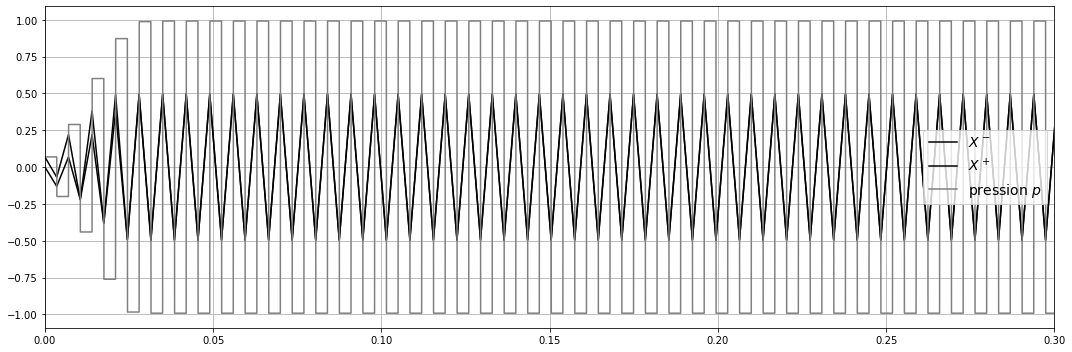

In [46]:
### Initialisation
Ncompute = len(compute_time)
Nsim = len(time_sim)

Xmoins_compute = np.zeros(Ncompute)
Xplus_compute = np.zeros(Ncompute)

zeta = 0.2
gamma = 0.6
F0,A,B,C = coeffs(gamma,zeta)

# Initialisation 

p0 = F0/(1-A)
u0 = Fapprox(p0,F0,A,B,C)

Xmoins_compute[0] = (p0 - u0)/2 
Xplus_compute[0] = (p0+u0)/2

# Calculs

for i in range(1,Ncompute):
    Xmoins_compute[i] = -G(Xmoins_compute[i-1],gamma,zeta,liste_G,x_G)
    X = G(Xmoins_compute[i],gamma,zeta,liste_G,x_G)
    Xplus_compute[i] = X
    
Xmoins = np.zeros(Nsim)
Xplus = np.zeros(Nsim)

i = 0
ind = 0
while i < Nsim and ind < Ncompute :
    Xmoins[i] = Xmoins_compute[ind]    
    Xplus[i] = Xplus_compute[ind]
    i+=1 
    time = i/fe
    ind = int(time//T) 
    
p = (Xmoins+Xplus)
f = (Xmoins-Xplus)

plt.figure(figsize=(15,5))
plt.plot(compute_time,Xmoins_compute,color='k',label=r'$X^-$')
plt.plot(compute_time,Xplus_compute,color='k',label=r'$X^+$')
plt.plot(time_sim,p,color='grey',label=r"pression $p$")
plt.legend(fontsize=14)
plt.grid()
plt.xlim(0,0.3)

plt.tight_layout()